# Topic Modeling of the television show Stargate SG1

## Motivations

I love the show Stargate SG1.  It is humorous with a level of self-awareness and does not take itself seriously, unlike some other sci-fi shows such as (Battlestar Gallactica or Stargate Universe).  Every year or so, I randomly re-watch the different seasons of the show.

The show ran for 10 seasons with a total of 214 episodes.  It spanned multiple worlds as the SG1 team traveled and met with multiple alien races, some are allies, some are enemies.  It also had its own lores involving alien technologies, alien vocabularies, US military vocabularies, ancient Egyptian mythologies and pop-culture references.  

Additionally, the episodes are generally self-contained, with the maximum that a storyline spans is around 2-3 episodes.  This makes the show easy to re-watch or to pick up at random spots without having to be updated of all the backgrounds and pertinent details.

The motivation of this project is to build a corpus of all the transcripts of the 10 seasons, explore if there are recurrent themes and group the episodes and/or seasons by them.  By doing so, I'm looking to map the essential words for each theme and also the episodes relating to each theme.  This would allow one to select a group of theme or storyline and be able to watch all the episodes relating to it.

## Overview

The following steps will be taken to explore this project:

- Create Pipeline to scrape the transcript data
- Preprocess and build a corpus of all the episodes
- Tokenize and create a dictionary of all the words used in the episodes
- Train and build embeddings from the tokens
- Model the topics
- Finally, explore the undercurrent themes and topics results

### Data Source

http://www.stargate-sg1-solutions.com/wiki/Transcripts appears to have the most complete transcripts for all 10 seasons.  The transcripts were compiled and archived by fans of the show.

### Tools

Methods / Tools to be used are:

- Python
- Beautifulsoup
- Trafilatura
- Gensim
- Sklearn
- Fasttext
- LDA
- HDBSCAN
- BertTopic
- Polars

## Step 0: imports

In [1]:
import sys
import re
import pathlib
import pickle
from copy import deepcopy
from typing import Iterator
import ftfy
from tqdm.auto import trange, tqdm
import numpy as np
import polars as pl
import plotly.express as px
import gensim
import spacy
import sklearn
import trafilatura
from trafilatura import spider
import courlan
import gc

gc.enable()
gc.collect()

0

## Step 1: Pipeline to Scrape Data

In [2]:
def get_transcript_links(urls: list) -> Iterator[set]:
    """
    get all the links for each season's page
    yield (generator) of sets
    """
    for season in urls:
        season_page = trafilatura.fetch_url(season, decode=True)
        links = spider.extract_links(
            pagecontent=season_page,
            base_url="http://www.stargate-sg1-solutions.com",
            external_bool=False,
        )
        yield links


def merge_uniqefy_links(links: Iterator[set]) -> set[str]:
    """
    merge the list of sets
    return a single set of unique links
    """
    all_links = set()
    for season in links:
        all_links.update(season)

    return all_links


def filter_links(links: set[str]) -> Iterator:
    """
    filter to only obtain the transcript links
    transcript url is of pattern: "wiki/[0-9].*Transcript"
    yield (generator) of links
    """
    link_pattern = re.compile(r"wiki\/\d.+Transcript$")

    for l in links:
        if re.search(link_pattern, l):
            yield l


def extract_transcripts(filtered_links: set[str]) -> Iterator[dict]:
    """
    extract the actual transcript from the set of transcript links
    yield (generator) of dicts
    """
    for l in filtered_links:
        page = trafilatura.fetch_url(l)
        extracted_page = trafilatura.bare_extraction(page)
        yield extracted_page


def clean_transcripts(transcripts: list[dict]) -> Iterator[dict]:
    # used to join character name with adjacent line where they talk
    pattern_1 = re.compile(r"(\n[A-Z]+.*[A-Z0-9]+)(\n)")

    # used to join character's reaction with adjacent line where they talk
    pattern_2 = re.compile(r"(\(.*\))\n")

    # used to match and select the stopping point of the transcripts
    pattern_3 = re.compile(r"^(Transcribe|(ROLL|END)\sCREDIT|FADE OUT).*")

    # correct some names:
    names = {"ONEILL": "O'NEILL", "TEALC": "TEAL'C", "BRATAC": "BRA'TAC"}

    for episode in transcripts:
        episode["text"] = ftfy.fix_text(episode["text"])

        for name in names:
            episode["text"] = re.sub(name, names[name], episode["text"])

        episode["text"] = re.sub(pattern_1, r"\1 ", episode["text"])
        episode["text"] = re.sub(pattern_2, r"\1 ", episode["text"])
        episode["text"] = episode["text"].split("\n")
        start_index = episode["text"].index("Transcript") + 1
        for n, e in enumerate(episode["text"]):
            if re.search(pattern_3, e):
                end_index = n - 1
        episode["text"] = episode["text"][start_index:end_index]
        yield episode


def run_extraction_pipeline(urls: list) -> list[dict]:
    # list of dicts
    # with the actual transcript stored in the dict's "text" key
    extracted_transcripts = list(
        clean_transcripts(
            extract_transcripts(
                filter_links(merge_uniqefy_links(get_transcript_links(urls)))
            )
        )
    )

    # sort the transcripts by episode title
    sorted_transcripts = sorted(extracted_transcripts, key=lambda x: x["title"])

    # pickle the transcripts
    with open("extracted_sg1_transcripts.pickle", "wb") as f:
        pickle.dump(sorted_transcripts, f)

    # transcripts is a list of dicts that include other metadata
    # with the key "text" containing the actual transcript
    return sorted_transcripts

In [3]:
urls = [
    "http://www.stargate-sg1-solutions.com/wiki/Season_One_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Two_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Three_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Four_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Five_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Six_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Seven_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Eight_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Nine_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Ten_Transcripts",
]

transcripts = run_extraction_pipeline(urls)

In [3]:
# load transcripts
with open("extracted_sg1_transcripts.pickle", "rb") as f:
    transcripts = pickle.load(f)

## Step 1.5: Exploring the characters' involvement statistics over the series

In [4]:
# Create a Polars dataframe to store statistics such as
# the number of times spoken and how many words are spoken

char_stats = pl.DataFrame()
char_regex_pattern = re.compile(r"([A-Z]+)([\-—\']*)([A-Z]+)")

for ep in transcripts:
    title = ep["title"]
    who_talks_most = {}
    who_talks_longest = {}

    for t in ep["text"]:
        mo = re.match(char_regex_pattern, t)
        if mo:
            words = len(re.sub(char_regex_pattern, "", t).split())
            if (mo.group() in who_talks_most.keys()) and (
                mo.group() in who_talks_longest.keys()
            ):
                who_talks_most[mo.group()] += 1
                who_talks_longest[mo.group()] += words
            else:
                who_talks_most[mo.group()] = 1
                who_talks_longest[mo.group()] = words

    char_stats = pl.concat(
        [
            char_stats,
            pl.DataFrame(
                {
                    "title": title,
                    "name": who_talks_most.keys(),
                    "frequency": who_talks_most.values(),
                    "words": who_talks_longest.values(),
                }
            ),
        ],
        how="vertical",
    )

char_stats = (
    char_stats.with_columns(pl.col("title").str.split(by=" "))
    .select(
        pl.col("title").list.get(0).cast(pl.Utf8).alias("episode").str.zfill(5),
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
    )
    .filter(
        ~pl.col("name").str.contains(
            "BEGIN|INT|EXT|ETX|TEASER|END|ROLL|FADE|CREDITS|FLASHBACK|ALTERNATE"
        )
    )
    .sort(["episode"], descending=False)
)

char_stats = char_stats.select(
    pl.col("episode").str.slice(0, 2).alias("season"),
    pl.col("episode").str.slice(3, 2).alias("episode"),
    pl.col("name"),
    pl.col("frequency"),
    pl.col("words"),
)

In [5]:
char_stats.head()

season,episode,name,frequency,words
str,str,str,i64,i64
"""01""","""01""","""AIRMAN""",21,148
"""01""","""01""","""FEMALE""",8,96
"""01""","""01""","""APOPHIS""",18,71
"""01""","""01""","""SF""",1,2
"""01""","""01""","""HAMMOND""",81,1024


### Over all Seasons by characters who speak the most and has the most words

In [6]:
# over all seasons by characters who speak the most and has the most words
over_all_seasons = (
    char_stats.groupby(["name"])
    .sum()
    .select(
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
        (pl.col("words") / pl.col("frequency")).alias("words/frequency"),
    )
    .sort(["frequency", "words", "words/frequency"], descending=[True, True, True])
    .filter(pl.col("words") >= 2000)
)

In [7]:
over_all_seasons.head()

name,frequency,words,words/frequency
str,i64,i64,f64
"""O'NEILL""",12285,91419,7.441514
"""CARTER""",11036,122351,11.086535
"""DANIEL""",9755,109895,11.265505
"""TEAL'C""",4724,46217,9.783446
"""HAMMOND""",3501,38411,10.971437


Over all seasons, Samantha Carter uses the most words.

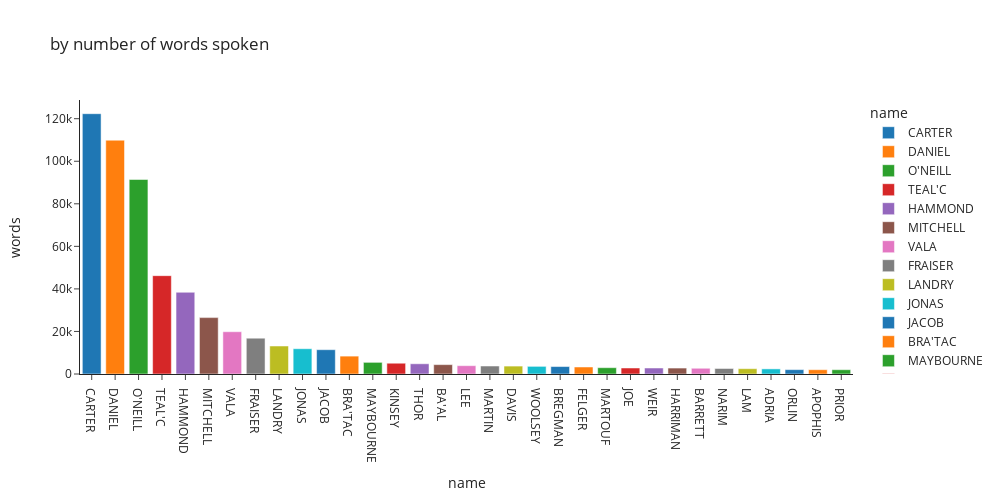

In [9]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("words", descending=True),
    x="name",
    y="words",
    color="name",
    title="by number of words spoken",
    template="simple_white",
    width=1000,
    height=500,
)

fig.show("png")

However, Over all seasons, Jack O'Neill talks the most often.

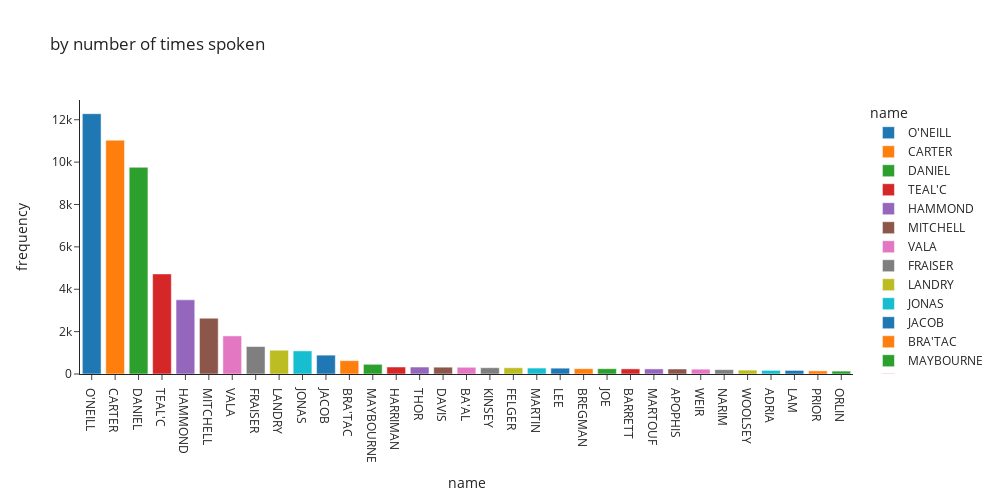

In [10]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("frequency", descending=True),
    x="name",
    y="frequency",
    color="name",
    title="by number of times spoken",
    template="simple_white",
    width=1000,
    height=500,
)
fig.show("png")

Long-winded-ness is defined as the number of words spoken / number of times spoken.

To no-one's surprise, the politicians of the show (Richard Woolsey and Senator Kinsey) are the most long-winded, using the most words for the little time that they talk.

On the other end of the spectrum, O'Neill is the most efficient with words.

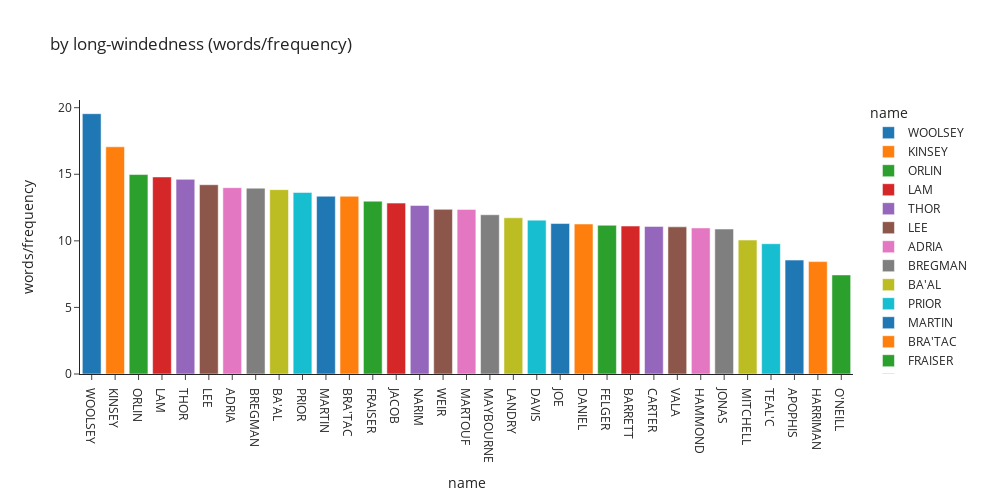

In [11]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("words/frequency", descending=True),
    x="name",
    y="words/frequency",
    color="name",
    title="by long-windedness (words/frequency)",
    template="simple_white",
    width=1000,
    height=500,
)

fig.show("png")

### Break down by each season

In [12]:
# by each season and characters who speak the most and has the most words
by_season = (
    char_stats.groupby(["season", "name"])
    .sum()
    .select(
        pl.col("season"),
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
        (pl.col("words") / pl.col("frequency")).alias("words/frequency"),
    )
    .sort(["season", "frequency", "words"], descending=[False, True, True])
)

In [13]:
by_season.head()

season,name,frequency,words,words/frequency
str,str,i64,i64,f64
"""01""","""O'NEILL""",1902,15563,8.18244
"""01""","""DANIEL""",1284,14515,11.304517
"""01""","""CARTER""",1176,11989,10.194728
"""01""","""TEAL'C""",600,5893,9.821667
"""01""","""HAMMOND""",598,7246,12.117057


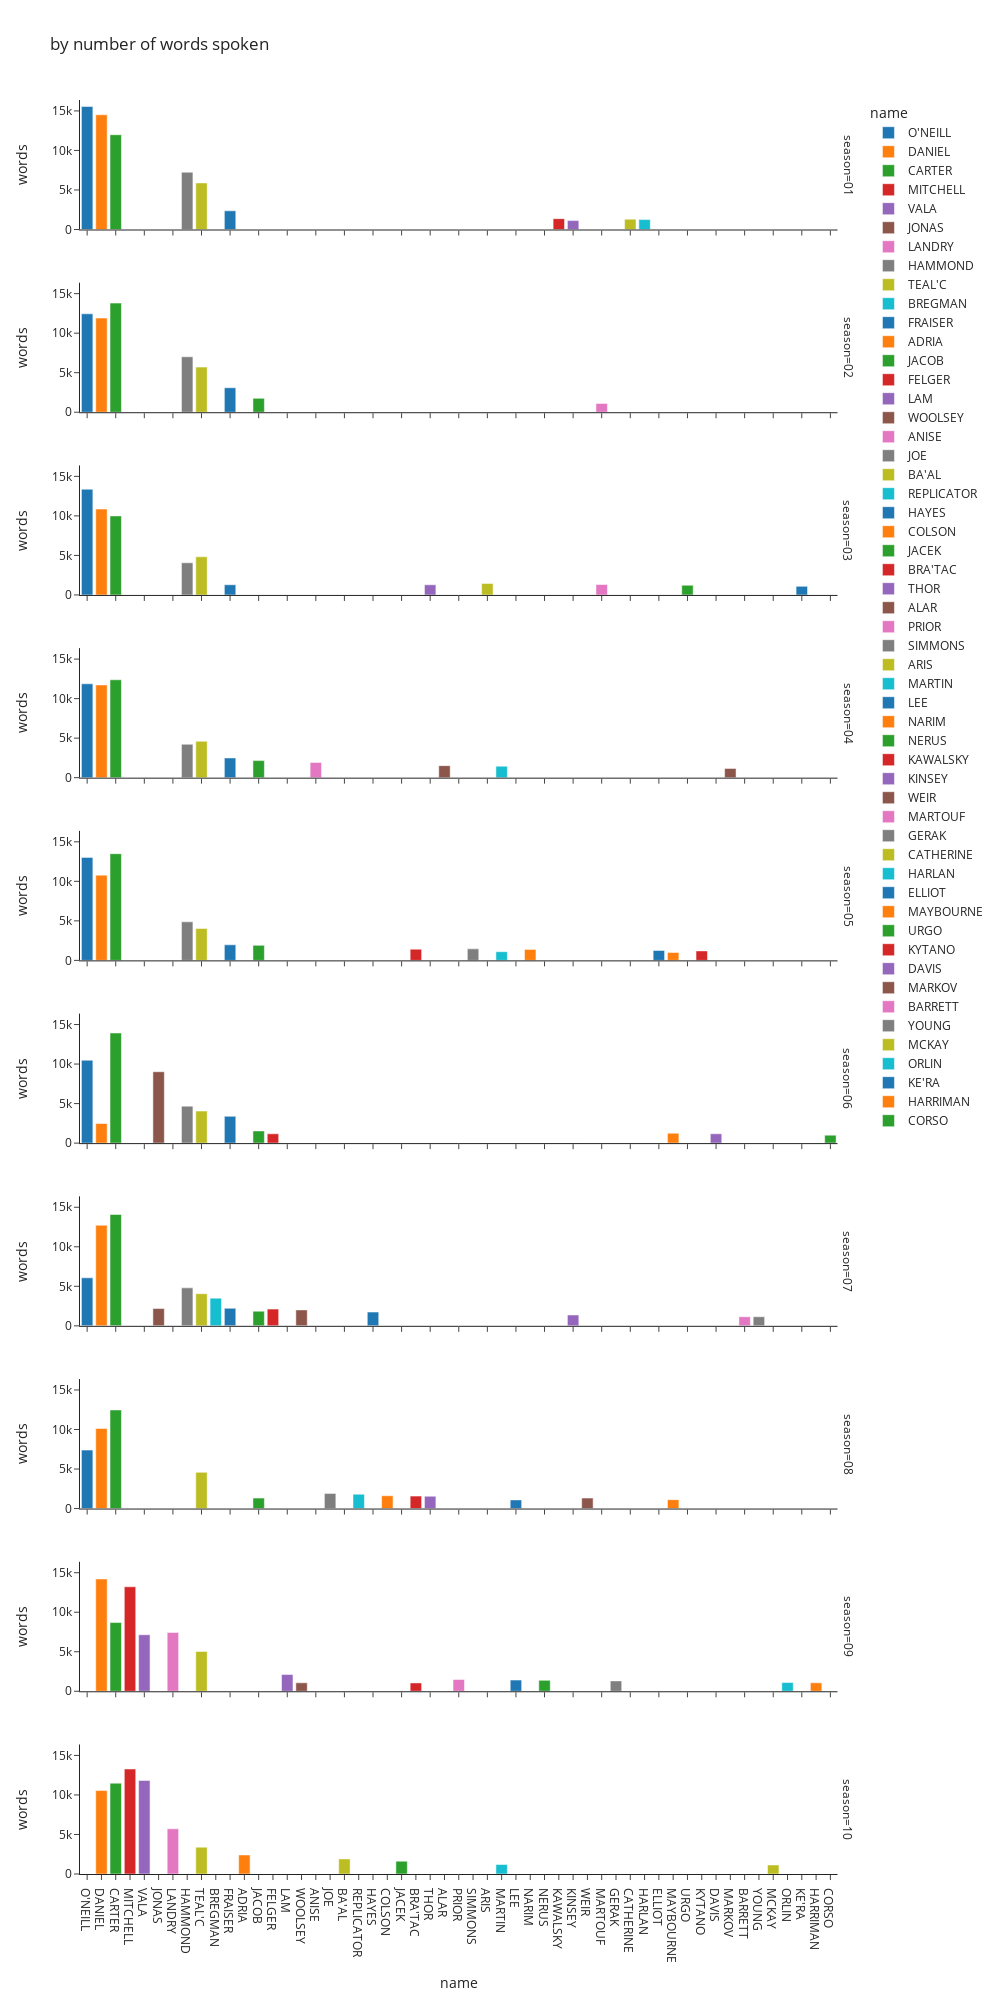

In [14]:
gc.collect()
fig = px.bar(
    by_season.sort("words", descending=True).filter(pl.col("words") >= 1000),
    x="name",
    y="words",
    color="name",
    title="by number of words spoken",
    facet_row="season",
    template="simple_white",
    category_orders={
        "season": by_season.select(pl.col("season"))
        .unique()
        .sort("season")
        .to_series()
        .to_list()
    },
    width=1000,
    height=2000,
)

fig.show("png")

### Heatmap of characters and number of words spoken over the seasons

In [15]:
words = (
    by_season.select(pl.exclude(["frequency", "words/frequency"]))
    .filter(
        pl.col("name").is_in(
            over_all_seasons.select(pl.col("name")).to_series().to_list()
        )
    )
    .pivot(index="season", columns="name", values="words", aggregate_function=None)
    .fill_null(0)
)

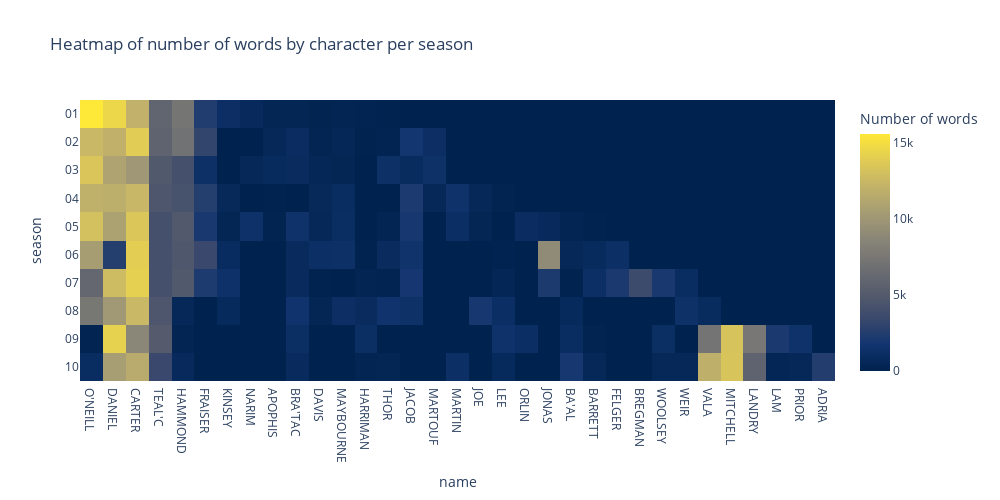

In [16]:
gc.collect()
fig = px.imshow(
    words.select(pl.exclude("season")).to_numpy(),
    width=1000,
    height=500,
    aspect="auto",
    x=words.columns[1:],
    y=words.select(pl.col("season")).to_series().to_list(),
    title="Heatmap of number of words by character per season",
    color_continuous_scale=px.colors.sequential.Cividis,
    labels=dict(x="name", y="season", color="Number of words"),
)

fig.show("png")

### Heatmap of how much more talkative a character becomes over the seasons

In [17]:
talktative = (
    by_season.select(pl.exclude(["words", "frequency"]))
    .filter(
        pl.col("name").is_in(
            over_all_seasons.select(pl.col("name")).to_series().to_list()
        )
    )
    .pivot(
        index="season",
        columns="name",
        values="words/frequency",
        aggregate_function=None,
    )
    .fill_null(0)
)

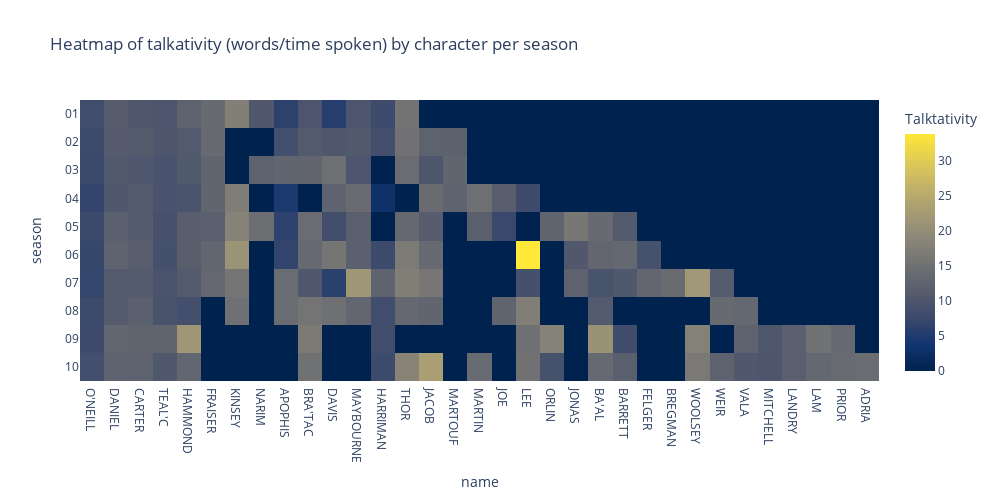

In [18]:
gc.collect()
fig = px.imshow(
    talktative.select(pl.exclude("season")).to_numpy(),
    width=1000,
    height=500,
    aspect="auto",
    x=talktative.columns[1:],
    y=talktative.select(pl.col("season")).to_series().to_list(),
    title="Heatmap of talkativity (words/time spoken) by character per season",
    color_continuous_scale=px.colors.sequential.Cividis,
    labels=dict(x="name", y="season", color="Talktativity"),
)

fig.show("png")

## Step 2: Preprocess and Build Corpus

In [19]:
def clean_corpus(corpus: Iterator[str]) -> Iterator[str]:
    # match the beginning
    pattern_1 = re.compile(r"(TEASER|FADE\sIN)")

    # match the speaker's name
    pattern_2 = re.compile(r"([A-Z]+)([\-—\']*)([A-Z]+)")

    # match two or more spaces
    pattern_3 = re.compile(r"(\s{2,})")

    for doc in corpus:
        doc = re.sub(pattern_1, "", doc).strip()
        doc = re.sub(pattern_2, "", doc).strip()
        doc = re.sub(pattern_3, " ", doc).strip()
        yield doc

In [20]:
corpus = (" ".join(t["text"]) for t in transcripts)
cleaned_corpus = list(clean_corpus(corpus))

# pickle the cleaned corpus
with open("cleaned_sg1_corpus.pickle", "wb") as f:
    pickle.dump(cleaned_corpus, f)

## Step 3: Create Dictionary, Tokenize and build Embeddings

In [29]:
# load the cleaned corpus
with open("cleaned_sg1_corpus.pickle", "rb") as f:
    corpus = pickle.load(f)

In [7]:
def clean_tokenize(docs: list[str]) -> Iterator[list]:
    """
    Input: docs: list of sentences
    Output: generator or list of lists of tokens
    """
    cleaned = (
        gensim.parsing.preprocessing.strip_multiple_whitespaces(
            gensim.parsing.preprocessing.strip_non_alphanum(gensim.utils.deaccent(doc))
        )
        .strip()
        .lower()
        for doc in docs
    )

    nlp = spacy.load("en_core_web_lg", exclude=["parser", "ner", "tok2vec"])

    # all the documents (rows) in the corpus
    sents = nlp.pipe(cleaned, n_process=6)

    # only keep the lemma form of the token and if token is alphabetic and not a stopword
    def ok_token(tok):
        if not tok.is_stop and len(tok) > 1 and not tok.like_num:
            return tok.lemma_
        else:
            return

    # iterate through each document and each token
    # return list of cleaned (lemmatized) strings
    # res = (ok_token(token) for sent in sents for token in sent if ok_token(token) != None)
    res = (
        [ok_token(token) for token in sent if ok_token(token) != None] for sent in sents
    )

    # clean up
    del docs
    del nlp
    del cleaned
    return res


def build_bow_corpus(cleaned_dataset: list[list[str]], dictionary) -> Iterator[list]:
    """
    Input: - cleaned_dataset: list of list of words
           - dictionary: gensim dictionary object
    Output: - generator of list of bags of words
    """
    for doc in cleaned_dataset:
        yield dictionary.doc2bow(doc, allow_update=True)

## Step 4: Topic Modeling

In [8]:
def tune_topics(corpus, id2word, sentences, n_topics: int):
    """
    Input:
        - corpus: list / generator of bags of words
        - id2word: gensim dictionary object
        - sentences: list / generator of tokens
        - n_topics: int number of topics
    Output:
        - Coherence value (float)
    """
    cores = 7
    lda_model = gensim.models.LdaMulticore(
        corpus=list(corpus), id2word=id2word, num_topics=n_topics, workers=cores
    )
    chr_model = gensim.models.CoherenceModel(
        model=lda_model,
        texts=sentences,
        dictionary=id2word,
        coherence="c_v",
        processes=cores,
    )
    return chr_model.get_coherence(), lda_model

## Step 5: Insights / Conclusions